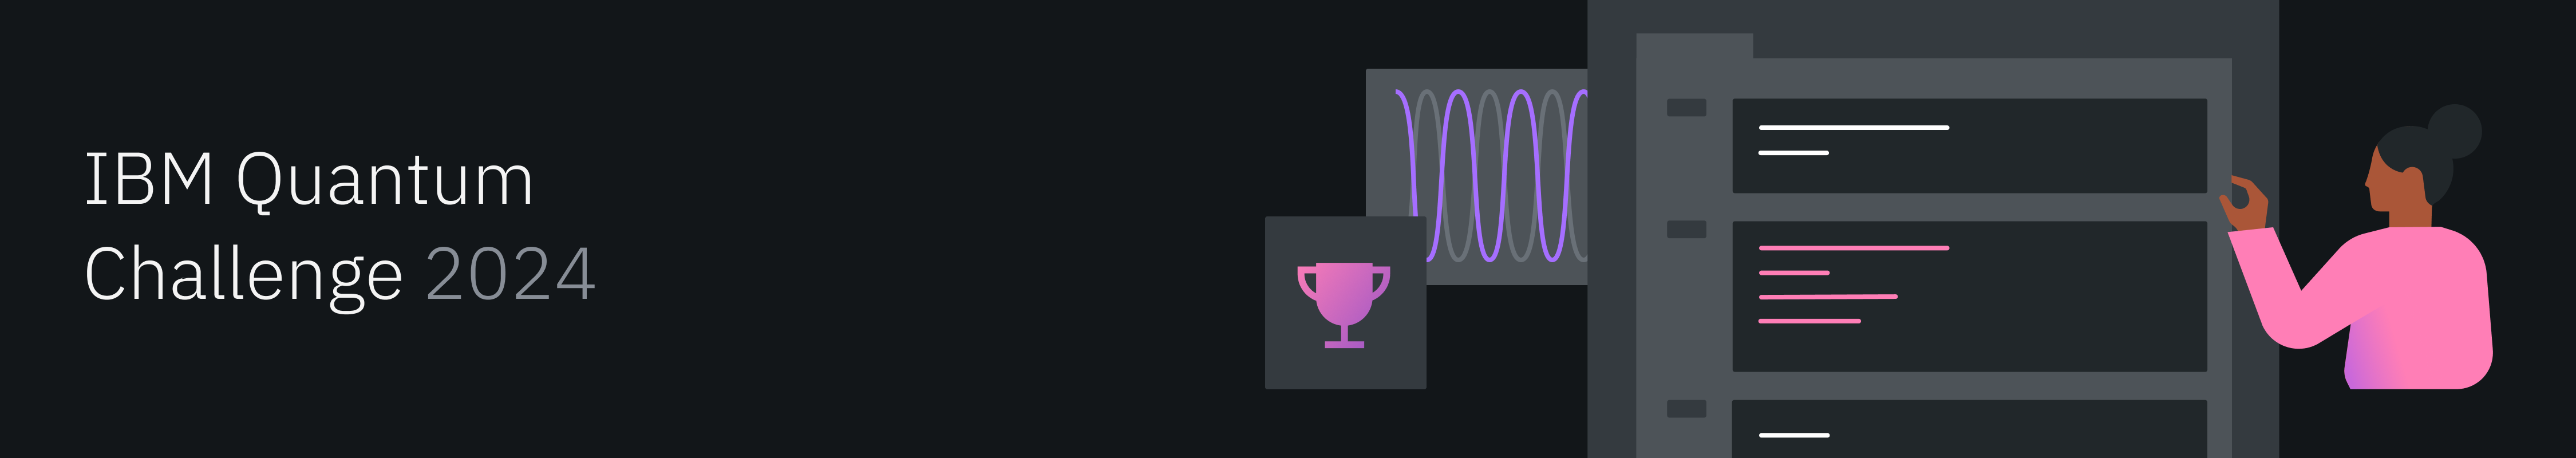

# Bonus Lab: Scaling to 50 qubits!


Ready to elevate your quantum computing skills? Your next challenge is to scale up the results from Lab 4 to 50 qubits! As the system size grows, we'll need to optimize our Variational Quantum Classifier (VQC) and reduce its depth. This is crucial because the mapping used for the `GHZ` state scales linearly with the number of qubits. We’ll adapt our quantum circuits to fit this larger scale and provide you with pre-trained optimal parameters. Your task is to test the functionality of the `VQC` in this extended qubit range.

**Why is this important?** Simulating more than 50 qubits is a significant feat in the quantum world and not many have ventured into running circuits of this size—it's a unique opportunity to push the boundaries of what's achievable in quantum simulations.

Please note, **this is a bonus lab** intended only for those who have successfully completed Lab 4, as it builds directly on the foundations and solutions you've developed. Dive into this advanced challenge and join the elite group experimenting at this level in quantum computing!

## Guideline

* [Step 1: Find a way to efficiently create GHZ states on 50 qubits](#Step-1:-Find-a-way-to-efficiently-create-GHZ-states-on-50-qubits)
* [Step 2: Adapt the `RealAmplitudes` ansatz to the new mapping](#Step-2:-Adapt-the-RealAmplitudes-ansatz-to-the-new-mapping)
* [Step 3: Check the optimal parameters using the `AerSimulator`](#Step-3:-Check-the-optimal-parameters-using-the-AerSimulator)
* [**Final step:** Testing a **50 qubit VQC on a quantum device (!)**](#Final-step:-Testing-a-50-qubit-VQC-on-a-quantum-device-(!))

Let's start by importing all the libraries that you will be needing in this Lab:

# Imports

In [ ]:
### Install Qiskit and relevant packages, if needed
### IMPORTANT: Make sure you are on 3.10 > python < 3.12
%pip install qiskit[visualization]==1.0.2
%pip install qiskit-ibm-runtime
%pip install qiskit-aer
%pip install graphviz
%pip install qiskit-serverless -U
%pip install qiskit-transpiler-service -U
%pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git -U

Now, let's run our imports

In [28]:
# Import all in one cell

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map, plot_circuit_layout, plot_distribution
from qiskit.circuit import ParameterVector

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

import warnings
warnings.filterwarnings('ignore')

In [29]:
### Save API Token, if needed

%set_env QXToken=a8046df1e73a916375c3edb2e50799b6a5e7c2cc4d068fd208598f035775b690a5c1572fbffd7c18f86eab95f404adf60e23a5ec375b2d94404ad09986d57986

# Make sure there is no space between the equal sign
# and the beginning of your token

env: QXToken=a8046df1e73a916375c3edb2e50799b6a5e7c2cc4d068fd208598f035775b690a5c1572fbffd7c18f86eab95f404adf60e23a5ec375b2d94404ad09986d57986


In [30]:
# qc-grader should be 0.18.13 (or higher)
import qc_grader

qc_grader.__version__

'0.18.13'

In [31]:
from qc_grader.challenges.iqc_2024 import grade_lab_bonus_ex1, grade_lab_bonus_ex2, grade_lab_bonus_ex3

## Step 1: Find a way to efficiently create GHZ states on 50 qubits

Start by recovering your amplitude embedding function from Lab 4:

In [32]:
# Function that returns a list of positions of each 1 in the binary-string representation of some number
def get_positions_of_ones(number):
    # Convert the number to a binary string and remove the '0b' prefix
    binary_string = bin(number)[2:]
    
    # Initialize an empty list to hold the positions of '1's
    positions = []
    
    # Iterate over the binary string in reverse (right to left)
    for index, bit in enumerate(reversed(binary_string)):
        if bit == '1':
            positions.append(index)
            
    return positions

In [33]:
def old_amplitude_embedding(num_qubits, bird_index):
    """Create amplitude embedding circuit

    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    # Function that returns a GHZ state from an empty quantum circuit
    def generate_GHZ(qc_test):
        qc_test.h(0)
        for i, j in zip(range(num_qubits-1), range(1,num_qubits-1)):
            qc_test.cx(i, j)
        return qc_test
    
    ### Write your code below here ###
    qc = QuantumCircuit(num_qubits)
    if(bird_index < 5):
        qc = generate_GHZ(qc)

    if(bird_index != 0):
        qc.x(get_positions_of_ones(bird_index))
    
    ### Don't change any code past this line ###
    return qc

The generation of the GHZ state in the previous `old_amplitude_embedding` function scales linearly with the number of qubits. You can check it using the following cells from Lab 4:

Depth of two-qubit gates:  48


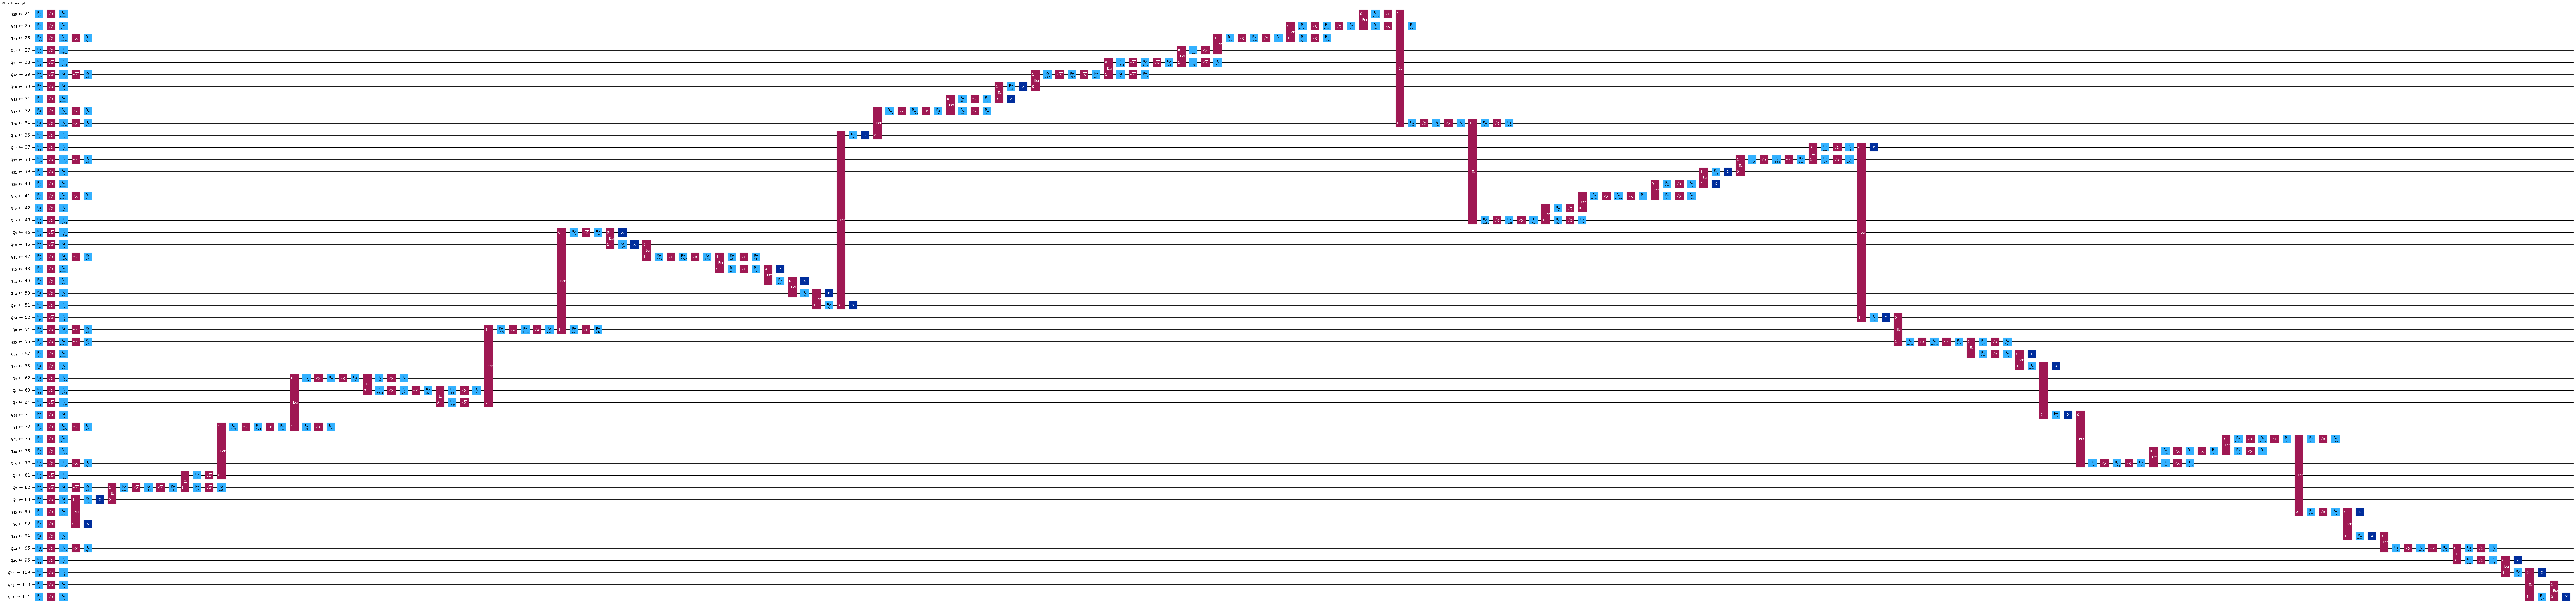

In [27]:
num_qubits = 50

# Choose a real backend
service = QiskitRuntimeService()
backend = service.backend("ibm_osaka")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

index_bird = 4 # You can check different birds by changing the index
qc = old_amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

If the two-qubit depth is of the order of 50 it is too large!! 

<a id="step1"></a>
<div class="alert alert-block alert-success">

**Task:** Find a way to efficiently encode the GHZ states in a large circuit and reduce the circuit two-qubit depth to 13 or less. This [blog post](https://dahalegopal27.medium.com/greetings-from-the-ibm-spring-challenge-map-of-127-qubits-ce08817176a7) can serve as inspiration!

> _The underlying concept leverages the symmetry in entangled qubits. Once two qubits are entangled, their symmetrical properties can be utilized to entangle additional qubits. This cascading entanglement process can be very efficient if the quantum system allows for all-to-all connectivity; in such a scenario, creating a GHZ state involving 
$𝑁$ qubits requires only an asymptotic complexity of $(O(\log(N)))$ steps._ 

> _However, in systems with heavy hexagonal (heavy hex) connectivity, the process is less efficient, and requires $(O(\sqrt{N}))$ steps to achieve the same._

</div> 

In [ ]:
def new_amplitude_embedding(num_qubits, bird_index):
    """Create efficient amplitude embedding circuit
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
            
    ### Write your code below here ###
    
    
    ### Don't change any code past this line ###
    return qc

The `matrix_product_state` [MPS](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html) method is more efficient than a full statevector simulation because it reduces the computational and memory demands. While the full statevector simulation requires exponential resources in relation to the number of qubits, MPS uses a tensor-based representation that scales more favorably, particularly in systems with low entanglement. This allows MPS to perform operations faster and with less memory in many scenarios, making it particularly effective for circuits that aren't heavily entangled and are low in depth. 

**You can find more about this in the documentation link [here.](https://qiskit.github.io/qiskit-aer/tutorials/7_matrix_product_state_method.html#id1)**

**You can use the following cell below to check that you are mapping the right states.**


<div class="alert alert-block alert-danger">

**Please note:** Please make sure your `GHZ` is constructed correct using the code block below. Try experimenting with different values of index and ensure you get a `GHZ` state.

</div>

In [ ]:
num_qubits = 50
index = 0 # Change to different values for testing
qc = new_amplitude_embedding(num_qubits, index)
qc.measure_all()

# Define the backend and the pass manager
aer_sim = AerSimulator(method='matrix_product_state')
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(qc)

# Define the sampler with the number of shots
sampler = Sampler(backend=aer_sim)
result = sampler.run([isa_circuit]).result()
samp_dist = result[0].data.meas.get_counts()
plot_distribution(samp_dist, figsize=(10, 3))

And you can check the new qubit two-qubit depth here:

In [ ]:
num_qubits = 50

# Choose a real backend
service = QiskitRuntimeService()
backend = service.backend("ibm_kyoto")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

index_bird = 0 #You can check different birds by changing the index
qc = new_amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
# Submit your answer using following code
grade_lab_bonus_ex1(new_amplitude_embedding(50,3)) # Expected answer type: QuantumCircuit

## Step 2: Adapt the `RealAmplitudes` ansatz to the new mapping

The previous ansatz needs to be adapted to the new connectiviy, but without increasing the layers. Check that, when transpiling the ansatz with `pairwise` connectivity together with the `new_amplitude_embedding`, the circuit is more than **100 layers(!)**

In [ ]:
def generate_old_ansatz(qubits):
    qc = RealAmplitudes(qubits, reps=1, entanglement='pairwise')
    return qc

num_qubits = 50

# Choose a real backend
service = QiskitRuntimeService()
backend = service.backend("ibm_kyoto")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

index_bird = 0 # You can check different birds by changing the index
qc = new_amplitude_embedding(num_qubits, index_bird)
ansatz = generate_old_ansatz(num_qubits)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled_qc = pm.run(qc.compose(ansatz))
print('Depth new mapping + old ansatz: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
# transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

<a id="exercise3"></a>
<div class="alert alert-block alert-success">

**Task:** Change the entanglement structure of the `RealAmplitudes` ansatz so that the total two-qubit depth of the circuit (embedding + ansatz) is reduced to **less than `15` layers**. 

*Hint: Consider the mapping that you have used for the `GHZ` state for the heavy hex lattice and try to entangle the qubits to the neighbouring ones if possible, with only 3 alternating layers.*

</div>  

In [ ]:
def generate_ansatz(num_qubits):
    """Generate a `RealAmplitudes` ansatz where all qubits are entangled with each other 
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
    
    Returns:
        qc (QuantumCircuit): Quantum circuit with the generated ansatz
    """
    ### Write your code below here ###





    
    ### Don't change any code past this line ###  
    return qc

##### Run this cell to check the total two-qubit depth

In [ ]:
index_bird = 0 # You can check different birds by changing the index
new_mapping_qc = new_amplitude_embedding(num_qubits, index_bird)
ansatz = generate_ansatz(num_qubits)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled_qc = pm.run(new_mapping_qc.compose(ansatz))
print('Depth new mapping + new ansatz: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
# transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
# Submit your answer using following code
grade_lab_bonus_ex2(transpiled_qc) # Expected answer type: QuantumCircuit

## Step 3: Check the optimal parameters using the `AerSimulator`

Now we need to generalize the optimal parameters for a 50 qubits VQC.

<a id="exercise3"></a>
<div class="alert alert-block alert-success">

**Task:** The optimal parameters array should have $\pi$ in the first rotation of `RealAmplitudes` for the qubits that are used to entangle other qubits and zero everywhere else. 

*Hint: The easiest way to do this is to generate a `source_list` which contains all qubits which are used as source for any `CX` operation in the ansatz.*

</div>  

In [ ]:
# Generate this to match your ansatz
source_list = # Add your code here

def generalize_optimal_params(num_qubits, ansatz, source_list):
    """Generate a `list of optimal parameters for N qubits 
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        ansatz (QuantumCircuit): Ansatz for our VQC
        source_list (list): List of qubits used as source to entangle other qubits
    
    Returns:
        opt_params (list): List of optimal parameters generated for N qubits
    """
    
    opt_params = np.zeros(ansatz.num_parameters)
    for i in range(ansatz.num_parameters//2):
        if i in source_list:
            opt_params[i] = np.pi

    return opt_params

<a id="exercise3"></a>
<div class="alert alert-block alert-success">

**Task:** Let's recover the `compute_performance` and the `test_shallow_VQC` functions from Lab 4, both to test with the `AerSimulator` and for a `QPU`. Modify the cost function by including a `-1` factor, as the parameters previously calculated are optimized for the inverse of the cost function. 

**Please note:** You need to use the `new_amplitude_embedding` and the `generate_ansatz` functions which you created above

</div>  

In [ ]:
def test_shallow_VQC_QPU(num_qubits, list_labels, obs, opt_params, options, backend):
    """Tests the shallow VQC on a QPU
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        list_labels (list): List of labels
        obs: (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Options for Estimator primitive
        backend (Backend): Real backend from IBM Quantum to run the job
    
    Returns:
        job_id (str): Job ID for Quantum job
    """

    ### Write your code below here ###

    
    ### Don't change any code past this line ###                         
                        
    return job_id

def retrieve_job(job_id):
    """Retrieve test results from job id
    Parameters: 
        job_id (str): Job ID
    Returns:
        results_test (list): List of test results
        errors_test (list): List of test errors
    """
    
    job = service.job(job_id)
    results_test = []
    errors_test = []
    for result in job.result():
        results_test.append(abs(abs(result.data.evs)-1)) #COST FUNCTION HAS A -1 NOW!!!
        errors_test.append(abs(result.data.stds))
        
    return results_test, errors_test

def test_shallow_VQC_CPU(num_qubits, list_labels, obs, opt_params, options, backend):
    """Tests the shallow VQC on a QPU
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        list_labels (list): List of labels
        obs: (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Options for Estimator primitive
        backend (Backend): AerSimulator backend to run the job
    
    Returns:
        results_test (list): List of test results
    """
    
    results_test = []
    ### Write your code below here ###



     ### Don't change any code past this line ### 
        result = job.result()[0].data.evs
        results_test.append(abs(abs(result)-1)) # COST FUNCTION NOW HAS A -1!!!  
                                           
    return results_test

def compute_performance(result_list, list_labels):
    """Return the performance of the classifier

    Parameters:
        result_list (list): List of results
        list_labels (list): List of labels
        
    Returns:
        performance (float): Performance of the classifier
    """
    ### Write your code below here ###


        
    ### Don't change any code past this line ###                                    
    return performance

Now we are ready to check if everything works using MPS (tensor networks). This is just to check the circuit and not to benchmark it, hence we are not transpiling the circuit nor applying any noise models.

<div class="alert alert-block alert-danger">

**Please note:** Please do not transpile before checking your result in the code below. This is just a check and not a benchmark.

</div>

In [ ]:
num_qubits = 50

aer_sim = AerSimulator(method='matrix_product_state')
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(new_mapping_qc)

list_labels = np.append(np.ones(5), np.zeros(5))
obs = SparsePauliOp("Z"*num_qubits)
opt_params = generalize_optimal_params(num_qubits, generate_ansatz(num_qubits), source_list)
options = EstimatorOptions()

results_test_aer_sim = test_shallow_VQC_CPU(num_qubits, list_labels, obs, opt_params, options, aer_sim)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data MPS')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
print(f"Performance for resilience 0: {compute_performance(results_test_aer_sim, list_labels)}")
ax.plot(results_test_aer_sim, 'o-', color='tab:red', label='MPS Num qubits = ' + str(num_qubits))
ax.plot(list_labels, 'k-', label='Labels')
ax.legend()

In [ ]:
# Submit your answer using following code
grade_lab_bonus_ex3(results_test_aer_sim) # Expected variable types: List

## Final step: Testing a 50 qubit VQC on a quantum device (!)

At this point, you should be all set to run your VQC on a real device!  Lets start by choosing our device. For this part of the Lab, we recommend choosing an IBM Quantum backend that you have access to, since we will use these simulations as a guide to run the code on the real backend later on. Take into account that the properties of the devices can change a lot from one to another, so testing the VQC might not work so well for certain devices. We have used [ibm_sherbrooke](https://quantum.ibm.com/services/resources?system=ibm_sherbrooke). 

You can find the list of systems you have access to on [the Systems tab](https://quantum.ibm.com/services/resources?resourceType=current-instance&order=queue%20ASC&view=table) on IBM Quantum platform or run the following code:

```python
    from qiskit_ibm_runtime import QiskitRuntimeService

    service = QiskitRuntimeService()
    # list all available systems
    service.backends()
    # get the least busy system
    backend = service.least_busy()
```


<div class="alert alert-block alert-danger">

**Please note:** Please perform the checks above before running it on the real device to ensure you make the best use of your QPU time.

</div>

In [ ]:
service = QiskitRuntimeService()
backend = service.backend("select_your_device")

Let us specify options for our real system run. You can review the explainations on `options` from [Lab 4](https://github.com/qiskit-community/ibm-quantum-challenge-2024/blob/main/content/lab_bonus/lab-bonus.ipynb#Zero-Noise-Extrapolation-(ZNE))

More detais about how to configure `options` for error mitigation with for Qiskit runtime can be found in [this tutorial](https://learning.quantum.ibm.com/tutorial/combine-error-mitigation-options-with-the-estimator-primitive) as well as in [the documentation](https://docs.quantum.ibm.com/run/configure-error-mitigation).




<div class="alert alert-block alert-danger">

**Please note:** For `10000` shots the estimated runtime is around 4 min and for `5000` it will be around 2 minutes. Please be mindful of the QPU time limitation you have on your account
</div>

In [ ]:
# RUN JOBS
num_qubits = 50
obs = SparsePauliOp("Z"*num_qubits)
opt_params = generalize_optimal_params(num_qubits, generate_ansatz(num_qubits), source_list)

for resilience in [0,1]:

    DD = True
    options = EstimatorOptions(default_shots = 5_000, 
                            optimization_level=0, 
                            resilience_level=resilience)  
    options.dynamical_decoupling.enable = DD
    options.dynamical_decoupling.sequence_type = 'XpXm'

    # OPTIONAL
    # options.resilience.zne_mitigation = True
    # options.resilience.zne.noise_factors = (1, 1.2, 1.5)
    # options.resilience.zne.extrapolator = ('exponential', 'linear', 'polynomial_degree_2') #order matters

    job_id = test_shallow_VQC_QPU(num_qubits, list_labels, obs, opt_params, options, backend)

##### You can use the cell below to plot your results

In [ ]:
results_test_0_DD, errors_test_0_DD = retrieve_job('Enter your JobID for resilience level 0') 
results_test_1_DD, errors_test_1_DD = retrieve_job('Enter your JobID for resilience level 1') 

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

##### Your results should look similar to the ones below. This is a previous job run using `ibm_kyiv`

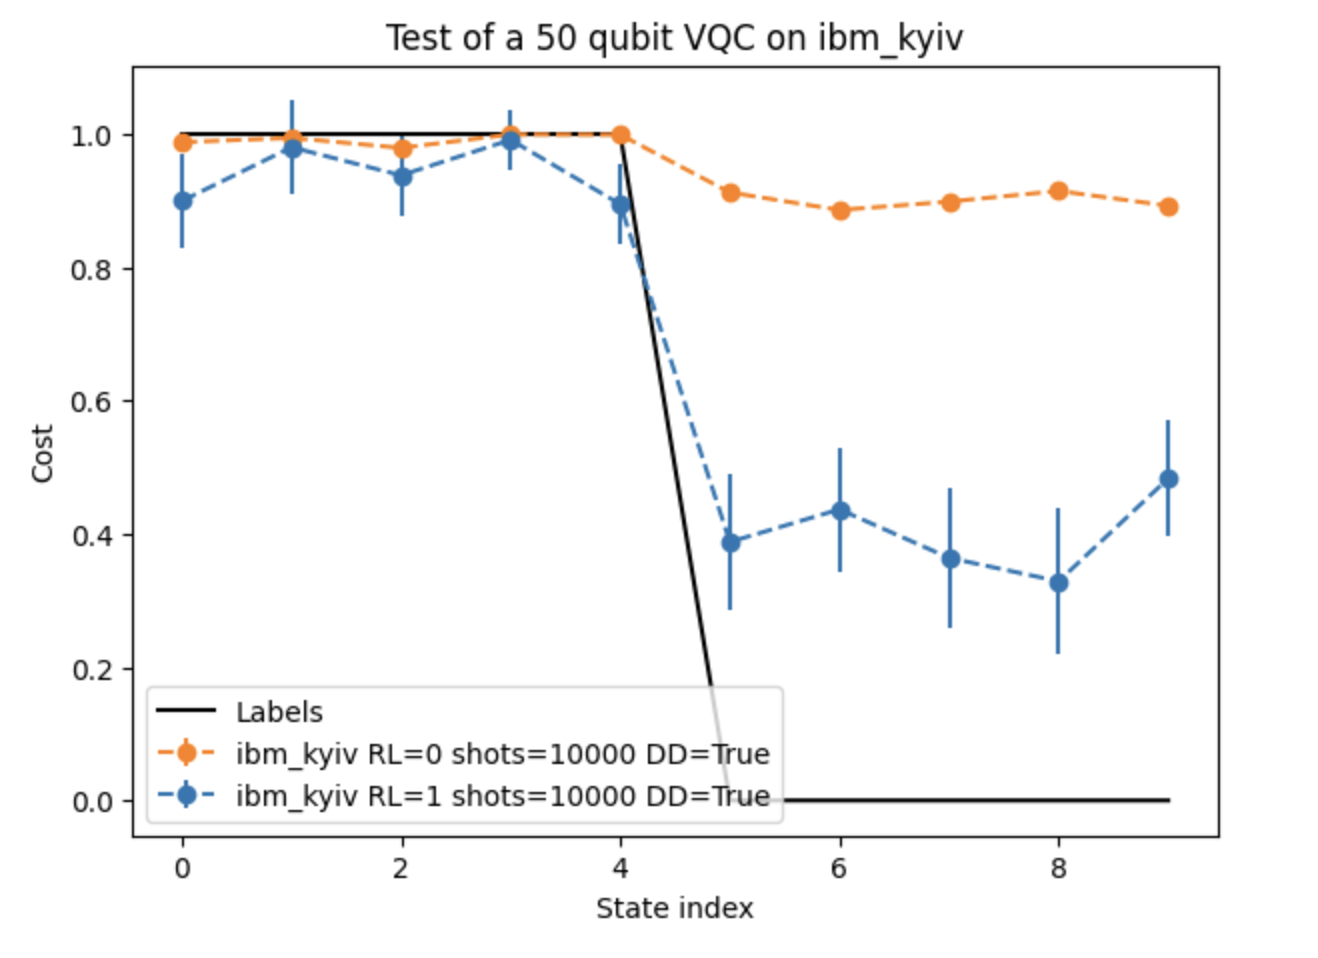

# Additional information

**Created by:** Joana Fraxanet, Marcel Pfaffhauser, Junye Huang, Vishal Sharathchandra Bajpe

**Advised by:** Pedro Rivero

**Version:** 1.0.0